# Feature Extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from google.colab.patches import cv2_imshow  # For displaying images in Google Colab

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import csv

In [ ]:
def extract_frames_from_videos(videos_folder, output_folder, frame_rate=60):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    video_files = sorted([os.path.join(videos_folder, f) for f in os.listdir(videos_folder) if f.endswith('.avi')])
    video_files = video_files[:1]  # Limit to first video
    frame_idx = 0
    for video_file in video_files:
        cap = cv2.VideoCapture(video_file)
        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps == 0:
            print(f"Warning: FPS of {video_file} is 0. Skipping this video.")
            continue
        #frame_interval = max(1, int(fps / frame_rate))
        frame_interval = 50
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if int(cap.get(cv2.CAP_PROP_POS_FRAMES)) % frame_interval == 0:
                frame_path = os.path.join(output_folder, f"frame_{frame_idx:06d}.png")
                success = cv2.imwrite(frame_path, frame)
                if not success:
                    print(f"Failed to write frame {frame_idx} to {frame_path}")
                frame_idx += 1
        cap.release()
    print(f"Extracted {frame_idx} frames to {output_folder}")

# Extract frames from the videos
videos_folder = '/content/drive/MyDrive/Emotion_Detection/s01/s01'
frames_folder = 'frames'
extract_frames_from_videos(videos_folder, frames_folder, frame_rate=60)

Extracted 60 frames to frames


yes


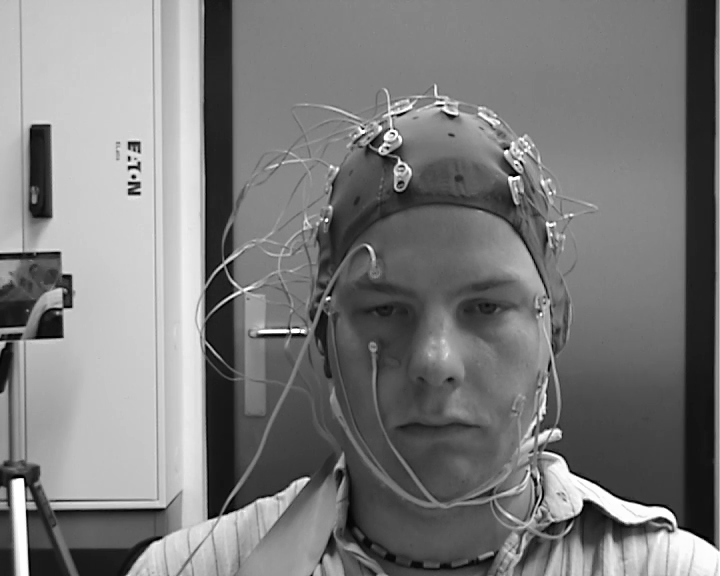

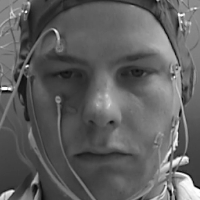

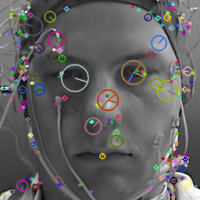

In [ ]:
def extract_sift_features(image):
    # Initialize the SIFT detector
    sift = cv2.SIFT_create()
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Initialize the face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) > 0:
        print("yes")
        # Use the first detected face
        x, y, w, h = faces[0]
        face = gray_image[y:y+h, x:x+w]
        # Resize the face to 100x100
        resized_face = cv2.resize(face, (200, 200))
    else:
        # If no face is detected, use the middle 100x100 region of the image
        height, width = gray_image.shape
        center_y, center_x = height // 2, width // 2
        start_y, start_x = center_y - 50, center_x - 50  # Adjust for 100x100 size
        resized_face = gray_image[start_y:start_y+200, start_x:start_x+200]
    # Detect and compute SIFT features
    keypoints, descriptors = sift.detectAndCompute(resized_face, None)
    frame_with_sift = cv2.drawKeypoints(resized_face, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return gray_image, resized_face, frame_with_sift

frame_file='/content/frames/frame_000000.png'
frame = cv2.imread(frame_file)
gray_image,resized_face,frame_with_sift=extract_sift_features(frame)
cv2_imshow(gray_image)
cv2_imshow(resized_face)
cv2_imshow(frame_with_sift)

Labels

In [ ]:
!pip install xlrd
!pip install xgboost

In [ ]:
#participant_ratings=pd.read_csv("/home/aaina/final_year_project/data/metadata_csv/participant_ratings.csv")
participant_ratings = pd.read_excel("/content/drive/MyDrive/DEAP/participant_ratings.xls", engine='xlrd')

#participant_ratings = pd.read_excel(r'C:/Users/Gpu/Downloads/participant_ratings.xls', engine='xlrd')
participant_ratings

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
0,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
1,1,2,18,2714905,7.23,7.15,6.94,8.01,4.0
2,1,3,4,3586768,4.94,6.01,6.12,8.06,4.0
3,1,4,24,4493800,7.04,7.09,8.01,8.22,4.0
4,1,5,20,5362005,8.26,7.91,7.19,8.13,1.0
...,...,...,...,...,...,...,...,...,...
1275,32,36,1,30916115,8.13,4.83,9.00,4.87,2.0
1276,32,37,18,31703107,8.03,7.06,8.96,8.18,5.0
1277,32,38,3,32482079,8.05,7.09,8.86,7.08,5.0
1278,32,39,25,33248922,4.01,7.17,8.01,6.94,2.0


In [ ]:
participant_ratings_drop=participant_ratings.drop(participant_ratings.index[880:])
participant_ratings_drop

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
0,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
1,1,2,18,2714905,7.23,7.15,6.94,8.01,4.0
2,1,3,4,3586768,4.94,6.01,6.12,8.06,4.0
3,1,4,24,4493800,7.04,7.09,8.01,8.22,4.0
4,1,5,20,5362005,8.26,7.91,7.19,8.13,1.0
...,...,...,...,...,...,...,...,...,...
875,22,36,10,33792963,4.00,6.06,6.03,5.00,1.0
876,22,37,33,34618848,1.96,7.06,2.94,1.00,1.0
877,22,38,2,35421074,7.08,7.05,6.06,7.12,2.0
878,22,39,25,36205478,2.95,4.90,2.96,7.05,1.0


In [ ]:
participant_ratings_drop=participant_ratings_drop.drop([119,199,437,438,439,559],axis=0)
participant_ratings_drop

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
0,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
1,1,2,18,2714905,7.23,7.15,6.94,8.01,4.0
2,1,3,4,3586768,4.94,6.01,6.12,8.06,4.0
3,1,4,24,4493800,7.04,7.09,8.01,8.22,4.0
4,1,5,20,5362005,8.26,7.91,7.19,8.13,1.0
...,...,...,...,...,...,...,...,...,...
875,22,36,10,33792963,4.00,6.06,6.03,5.00,1.0
876,22,37,33,34618848,1.96,7.06,2.94,1.00,1.0
877,22,38,2,35421074,7.08,7.05,6.06,7.12,2.0
878,22,39,25,36205478,2.95,4.90,2.96,7.05,1.0


In [ ]:
participant_ratings_drop[119:120]

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
120,4,1,20,2644761,8.17,8.05,6.08,9.0,2.0


In [ ]:
participant_ratings_drop[197:200]

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
198,5,39,39,39936870,1.00,4.86,7.05,1.00,1.0
200,6,1,31,4863503,3.65,3.49,4.05,6.36,1.0
201,6,2,5,5941302,7.01,7.38,6.55,7.36,5.0


In [ ]:
participant_ratings_drop

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
0,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
1,1,2,18,2714905,7.23,7.15,6.94,8.01,4.0
2,1,3,4,3586768,4.94,6.01,6.12,8.06,4.0
3,1,4,24,4493800,7.04,7.09,8.01,8.22,4.0
4,1,5,20,5362005,8.26,7.91,7.19,8.13,1.0
...,...,...,...,...,...,...,...,...,...
875,22,36,10,33792963,4.00,6.06,6.03,5.00,1.0
876,22,37,33,34618848,1.96,7.06,2.94,1.00,1.0
877,22,38,2,35421074,7.08,7.05,6.06,7.12,2.0
878,22,39,25,36205478,2.95,4.90,2.96,7.05,1.0


In [ ]:
#s01-s04:participant_ratings_drop[:159]
#s05:participant_ratings_drop[159:198]
#s06-s22:participant_ratings_drop[198:]
#
sift_labels1=pd.concat([participant_ratings_drop[:159]]*50).sort_index()
sift_labels2=pd.concat([participant_ratings_drop[159:198]]*60).sort_index()
sift_labels3=pd.concat([participant_ratings_drop[198:]]*50).sort_index()
sift_labels = pd.concat([sift_labels1, sift_labels2 , sift_labels3], ignore_index=True)
sift_labels

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity
0,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
1,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
2,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
3,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
4,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0
...,...,...,...,...,...,...,...,...,...
44085,22,40,35,37007533,1.99,7.08,4.08,1.00,1.0
44086,22,40,35,37007533,1.99,7.08,4.08,1.00,1.0
44087,22,40,35,37007533,1.99,7.08,4.08,1.00,1.0
44088,22,40,35,37007533,1.99,7.08,4.08,1.00,1.0


In [ ]:
df_combine=sift_labels

In [ ]:
df_combine.loc[df_combine['Valence'] <=4.5, 'Valence_label'] = 0
df_combine.loc[df_combine['Valence'] >4.5, 'Valence_label'] = 1

In [ ]:
df_combine.loc[df_combine['Arousal'] <=4.5, 'Arousal_label'] = 0
df_combine.loc[df_combine['Arousal'] >4.5, 'Arousal_label'] = 1

In [ ]:
df_combine.loc[df_combine['Dominance'] <=4.5, 'Dominance_label'] = 0
df_combine.loc[df_combine['Dominance'] >4.5, 'Dominance_label'] = 1

In [ ]:
df_combine.loc[df_combine['Liking'] <=4.5, 'Liking_label'] = 0
df_combine.loc[df_combine['Liking'] >4.5, 'Liking_label'] = 1

In [ ]:
df_combine[1:60]

,Participant_id,Trial,Experiment_id,Start_time,Valence,Arousal,Dominance,Liking,Familiarity,Valence_label,Arousal_label,Dominance_label,Liking_label
1,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
2,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
3,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
4,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
5,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
6,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
7,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
8,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
9,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
10,1,1,5,1695918,6.96,3.92,7.19,6.05,4.0,1.0,0.0,1.0,1.0
